In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision
from pytorch_lightning import LightningModule, Trainer
from sklearn.model_selection import train_test_split

import albumentations as A
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2
import os
import glob

%matplotlib inline


In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [3]:
list_train = glob.glob('../FullIJCNN2013' + '/*')
list_train = [string.split('/')[-1] for string in list_train if '.ppm' in string]
len(list_train), list_train[0]


(900, '00316.ppm')

In [4]:
BOX_COLOR = (255, 0, 0)  # Red
TEXT_COLOR = (255, 255, 255)  # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    # x_min, y_min, w, h = bbox
    bbox = [int(i) for i in bbox]
    x_min, y_min, x_max, y_max = bbox

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(str(class_name), cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=str(class_name),
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35,
        color=TEXT_COLOR,
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name=None):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        if category_id_to_name:
            class_name = category_id_to_name[category_id]
        class_name = category_id
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)


In [5]:
import pandas as pd


In [6]:
data = pd.read_csv('../FullIJCNN2013/gt.txt', sep=';', header=None)
data.rename(columns={0: "image", 5: "class"}, inplace=True)
data.head()


,image,1,2,3,4,class
0,00000.ppm,774,411,815,446,11
1,00001.ppm,983,388,1024,432,40
2,00001.ppm,386,494,442,552,38
3,00001.ppm,973,335,1031,390,13
4,00002.ppm,892,476,1006,592,39


<AxesSubplot:ylabel='Frequency'>

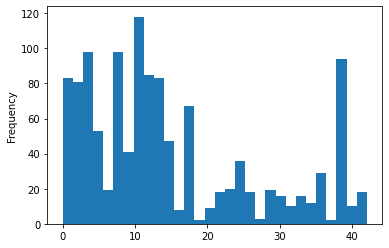

In [7]:
data['class'].plot.hist(bins=30)


In [8]:
data[data['image'] == '00001.ppm']


,image,1,2,3,4,class
1,00001.ppm,983,388,1024,432,40
2,00001.ppm,386,494,442,552,38
3,00001.ppm,973,335,1031,390,13


In [9]:
data_for_split = data['image'].unique()


In [10]:
# data.drop(data[(data['class'] == 41) | (data['class'] == 42)].index, inplace=True)
# data.reset_index(drop=True, inplace=True)
# data


In [11]:
# data[data['class'] == 32].head() # 12, 14, 17, 41 ,42


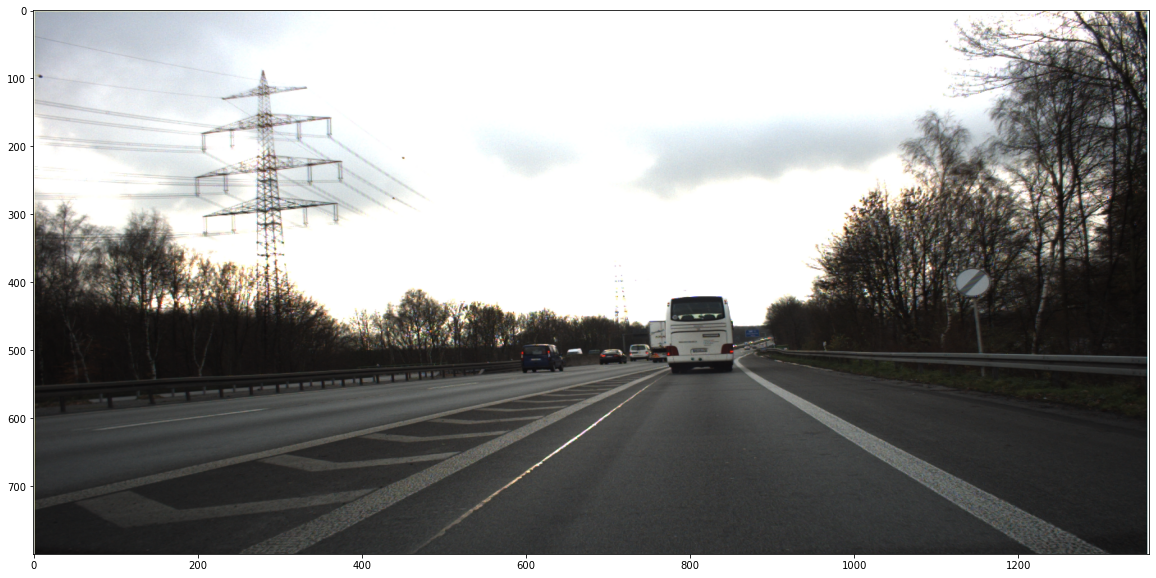

In [12]:
im = cv2.imread('../FullIJCNN2013/00317.ppm')
im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
plt.figure(figsize=(20, 10))
plt.imshow(im, aspect='auto')


In [13]:
def get_label(label):
    prohibitory = [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 15, 16]  # (circular, white ground with red border)
    mandatory = [33, 34, 35, 36, 37, 38, 39, 40]  # (circular, blue ground)
    danger = [11, 13, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
              29, 30, 31]  # (triangular, white ground with red border)
    # rare = [12, 14, 17, 41 ,42]

    if label in prohibitory:
        new_label = 1
    elif label in mandatory:
        new_label = 2
    elif label in danger:
        new_label = 3
    else:
        new_label = 4

    return new_label


def get_label_new(label):
    return 0


In [14]:
data['class'] = data['class'].apply(get_label)


In [15]:
data.iloc[1102]


image    00808.ppm
1              272
2              463
3              315
4              507
class            2
Name: 1102, dtype: object

In [16]:
ser = data[data['image'] == '00001.ppm']


In [17]:
for index, row in ser.iterrows():
    print(index)
    print(row['image'])


1
00001.ppm
2
00001.ppm
3
00001.ppm


<AxesSubplot:ylabel='Frequency'>

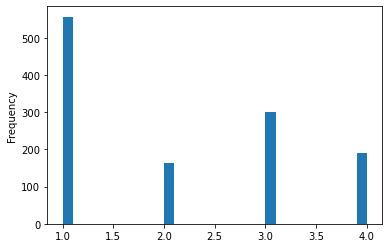

In [18]:
data['class'].plot.hist(bins=30)


In [19]:
# stratify = data['class'].value_counts(sort=False).sort_index().values


In [20]:
train, val = train_test_split(data, test_size=0.15, stratify=data['class'])


In [21]:
train.reset_index(inplace=True, drop=True)
val.reset_index(inplace=True, drop=True)


In [22]:
train = train['image'].unique()


In [23]:
val = val['image'].unique()
val


array(['00520.ppm', '00164.ppm', '00366.ppm', '00265.ppm', '00368.ppm',
       '00088.ppm', '00374.ppm', '00174.ppm', '00105.ppm', '00033.ppm',
       '00300.ppm', '00259.ppm', '00865.ppm', '00770.ppm', '00806.ppm',
       '00798.ppm', '00607.ppm', '00408.ppm', '00717.ppm', '00330.ppm',
       '00448.ppm', '00482.ppm', '00231.ppm', '00721.ppm', '00224.ppm',
       '00415.ppm', '00471.ppm', '00797.ppm', '00723.ppm', '00081.ppm',
       '00701.ppm', '00398.ppm', '00467.ppm', '00257.ppm', '00397.ppm',
       '00035.ppm', '00206.ppm', '00073.ppm', '00400.ppm', '00380.ppm',
       '00528.ppm', '00126.ppm', '00817.ppm', '00023.ppm', '00322.ppm',
       '00809.ppm', '00006.ppm', '00564.ppm', '00396.ppm', '00118.ppm',
       '00434.ppm', '00650.ppm', '00115.ppm', '00490.ppm', '00527.ppm',
       '00509.ppm', '00351.ppm', '00241.ppm', '00473.ppm', '00518.ppm',
       '00730.ppm', '00894.ppm', '00003.ppm', '00871.ppm', '00198.ppm',
       '00040.ppm', '00457.ppm', '00405.ppm', '00870.ppm', '0005

In [24]:
len(val)


163

In [25]:
inter = list(set(train) & set(val))
inter[:5]


['00307.ppm', '00380.ppm', '00073.ppm', '00322.ppm', '00722.ppm']

In [26]:
new_val = set(val) - set(inter)
len(new_val)


69

In [27]:
new_val = list(new_val)
val = new_val


In [28]:
def get_training_augmentation():
    train_transform = [

        A.GaussNoise(p=0.2),
        # A.Perspective(p=0.5),
        A.PadIfNeeded(min_height=640, min_width=640, always_apply=True, border_mode=0),

        A.OneOf([
            A.RandomSizedBBoxSafeCrop(width=240, height=120),
            A.RandomSizedBBoxSafeCrop(width=320, height=240),
            A.RandomSizedBBoxSafeCrop(width=480, height=320),
            A.RandomSizedBBoxSafeCrop(width=640, height=480),
        ], p=1
        ),
        A.Resize(640, 480),
        A.HorizontalFlip(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightnessContrast(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.8,
        ),

        A.OneOf(
            [
                A.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.8,
        ),

        A.OneOf(
            [
                A.RandomBrightnessContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.8,
        ),
        A.Normalize(),
    ]
    return A.Compose(
        train_transform, bbox_params=A.BboxParams(
            format='pascal_voc', label_fields=['category_ids'],
            min_visibility=0.5))


In [29]:
transform_tr = get_training_augmentation()
transform = A.Compose([
    A.OneOf([
        A.RandomSizedBBoxSafeCrop(width=240, height=120),
        A.RandomSizedBBoxSafeCrop(width=320, height=240),
        A.RandomSizedBBoxSafeCrop(width=480, height=320),
        A.RandomSizedBBoxSafeCrop(width=640, height=480),
    ], p=1
    ),
    A.Resize(width=640, height=480),
    # A.HorizontalFlip(p=0.5),
    # A.RandomBrightnessContrast(p=0.5),
    A.Normalize(),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))


In [31]:
class DetectionDataset(Dataset):
    def __init__(self, data, names, root, transforms=None):
        self.data = data
        self.root = root
        self.transforms = transforms
        self.names = names

    def __getitem__(self, idx):
        name = self.names[idx]
        df = self.data[self.data['image'] == name]
        img_path = os.path.join(self.root, name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        bboxes = []
        labels = []
        for index, row in df.iterrows():
            bboxes.append([int(row[1]), int(row[2]), int(row[3]), int(row[4])])
            labels.append(row['class'])

        if self.transforms is not None:
            transformed = self.transforms(image=img, bboxes=bboxes, category_ids=labels)
            img = transformed['image']
            bboxes = transformed['bboxes']
            labels = transformed['category_ids']
        target = {}
        target["boxes"] = torch.as_tensor(bboxes, dtype=torch.float)
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
        img = torch.as_tensor(img).float().permute(2, 0, 1)
        return img, target

    def __len__(self):
        return len(self.names)


def collate_fn(batch):
    return tuple(zip(*batch))


In [32]:
train_set = DetectionDataset(data, train, '../FullIJCNN2013',
                             transform_tr
                             )
val_set = DetectionDataset(data, val, '../FullIJCNN2013',
                           transform
                           )


In [33]:
im, targets = train_set[2]


In [35]:
im.shape, targets


(torch.Size([3, 640, 480]),
 {'boxes': tensor([[131.7818, 562.8275, 144.0000, 598.7526]]),
  'labels': tensor([3])})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


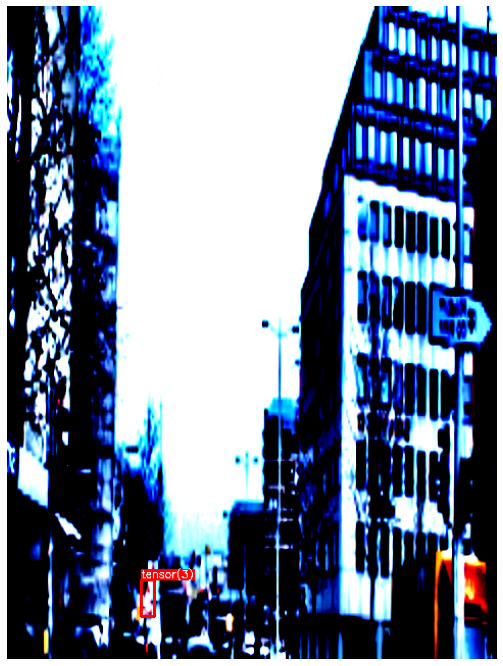

In [36]:
visualize(im.permute(1, 2, 0).numpy(), targets['boxes'], targets['labels'])


In [37]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN_ResNet50_FPN_V2_Weights


In [39]:
data_loader = torch.utils.data.DataLoader(
    train_set, batch_size=12, shuffle=True, num_workers=20, collate_fn=collate_fn,
)
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=1, num_workers=4, collate_fn=collate_fn,
)


In [43]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2


In [45]:
class FasterRCNN(LightningModule):
    def __init__(self, n_classes):
        super().__init__()
        self.detector = fasterrcnn_resnet50_fpn_v2(weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT)
        in_features = self.detector.roi_heads.box_predictor.cls_score.in_features
        self.detector.roi_heads.box_predictor = FastRCNNPredictor(in_features, n_classes)
        self.lr = 1e-3
        self.metric = MeanAveragePrecision()

    def forward(self, imgs, targets=None):
        # Torchvision FasterRCNN returns the loss during training
        # and the boxes during eval
        self.detector.eval()
        return self.detector(imgs)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = {'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer, mode='min', factor=0.7, patience=7), 'monitor': 'train_loss_step', }
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
        }

    def training_step(self, batch, batch_idx):
        images, targets = batch
        targets = [{k: v.cuda() for k, v in t.items()} for t in targets]
        # fasterrcnn takes both images and targets for training, returns
        loss_dict = self.detector(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        self.log('train_loss_step', loss.detach(), on_step=True)
        return {"loss": loss, "log": loss_dict}

    def validation_step(self, batch, batch_idx):
        img, boxes = batch
        pred_boxes = self.forward(img)
        self.val_loss = self.metric(pred_boxes, boxes)
        self.log('val_step', self.val_loss['map'], on_step=True)
        return {"val_loss": self.val_loss['map']}

    def validation_epoch_end(self, outputs):
        loss_val = torch.stack([x["val_loss"] for x in outputs]).mean()
        log_dict = {"val_loss": loss_val.detach()}
        # Логи валидационных эпох для tensorboard
        self.log('val_epoch_total_step', log_dict['val_loss'], on_epoch=True)
        return log_dict['val_loss']


In [46]:
det_model = FasterRCNN(5)


In [48]:
from pytorch_lightning.callbacks import ModelCheckpoint


In [49]:
path_loc = '3class_v1'
checkpoint_callback = ModelCheckpoint(
    dirpath=f"../lightning_logs/detection/{path_loc}", save_top_k=2, monitor="val_epoch_total_step", mode='max')


In [51]:
trainer = Trainer(gpus=1,
                  max_epochs=100,
                  callbacks=[checkpoint_callback],
                  default_root_dir=f'../lightning_logs/detection/{path_loc}'
                  )


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [52]:
trainer.fit(det_model,
            data_loader, val_loader,
            )


Missing logger folder: ../lightning_logs/detection/3class_v1/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                 | Params
--------------------------------------------------
0 | detector | FasterRCNN           | 43.3 M
1 | metric   | MeanAveragePrecision | 0     
--------------------------------------------------
43.0 M    Trainable params
225 K     Non-trainable params
43.3 M    Total params
173.086   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/tim/miniconda3/envs/geo/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:72: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/tim/miniconda3/envs/geo/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [58]:
torch.save(det_model.to('cpu'), '../lightning_logs/detection/3class_v1/detection_model_3.pt')
